In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Required Modules

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample

sns.set_theme(style="darkgrid")

# Loading the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Yelp/yelp_database.csv', low_memory=False)

In [ ]:
df.head()

,ID,Time_GMT,Phone,Organization,OLF,Rating,NumberReview,Category,Country,CountryCode,State,City,Street,Building
0,1,3/12/2021 2:10,12562343500,The Station's Best,NaN,4.0,4,Delivery,USA,US,AL,Alexander City,Jefferson,977
1,2,3/12/2021 2:10,12566758004,Pizza Hut,NaN,3.0,6,Delivery,USA,US,AL,Alexander City,4581 Hwy,4581
2,3,3/12/2021 2:10,12562342181,Zaxby's Chicken Fingers & Buffalo Wings,NaN,3.0,13,Delivery,USA,US,AL,Alexander City,4497 Highway,4497
3,4,3/12/2021 2:10,12564097272,Papa John's Pizza,NaN,1.0,1,Delivery,USA,US,AL,Alexander City,2064 Cherokee,2064
4,5,3/12/2021 2:10,12562155510,Arby's,NaN,2.0,7,Delivery,USA,US,AL,Alexander City,2593 Hwy,2593


# Cleaning the data | Feature Engineering

In [ ]:
# Missing Values
df['OLF_isINC'] = df['OLF'].apply(lambda x: 1 if x=='INC' else 0) # Preserving the INC data
df['OLF_isLLP'] = df['OLF'].apply(lambda x: 1 if x=='LLP' else 0) # Preserving the LLP data
df.drop('OLF', axis=1, inplace=True)

In [ ]:
# Cleaning time and date | Removing the ID (index column)
df['date'] = df['Time_GMT'].apply(lambda x: x.split(sep=' ')[0])
df['time'] = df['Time_GMT'].apply(lambda x: x.split(sep=' ')[1])
df['DateTime'] = pd.to_datetime(df['date'] +" " + df['time'] )
df.drop(['date','time'], axis=1, inplace=True)
df.drop(['Time_GMT','ID'], axis=1, inplace=True)


In [ ]:
# Removing Single value columns
df.drop(['Country', 'CountryCode'], axis=1, inplace=True)

In [ ]:
# Month and Day column
df['month'] = df['DateTime'].apply(lambda x: x.month)
df['day'] = df['DateTime'].apply(lambda x: x.day)

In [ ]:
# Average Rating per Org
avgRating = df.groupby('Organization')['Rating'].mean().to_dict()
df['avgRating_org'] = df['Organization'].map(avgRating)

# Total Ratings per Org
TotalReviews = df['Organization'].value_counts().to_dict()
df['TotalReviews_org'] = df['Organization'].map(TotalReviews)

In [ ]:
# Average Rating per City
avgRating_City = df.groupby('City')['Rating'].mean().to_dict()
df['avgRating_City'] = df['City'].map(avgRating_City)

# Total Ratings per City
TotalReviews_City = df['City'].value_counts().to_dict()
df['TotalReviews_City'] = df['City'].map(TotalReviews_City)

In [ ]:
# Average Rating per State
avgRating_State = df.groupby('State')['Rating'].mean().to_dict()
df['avgRating_State'] = df['State'].map(avgRating_State)

# Total Ratings per State
TotalReviews_State = df['State'].value_counts().to_dict()
df['TotalReviews_State'] = df['State'].map(TotalReviews_State)

In [ ]:
# Average Rating per Month
avgRating_month = df.groupby('month')['Rating'].mean().to_dict()
df['avgRating_month'] = df['month'].map(avgRating_month)

# Total Ratings per month
TotalReviews_month = df['month'].value_counts().to_dict()
df['TotalReviews_month'] = df['month'].map(TotalReviews_month)

In [ ]:
# Number of Branches per Organization
TotalBranches = df.groupby(['Organization'])['City'].nunique().to_dict()
df['TotalBranches'] = df['Organization'].map(TotalBranches)

In [ ]:
# Average rating per branch


avg_BranchRating = df.groupby(['Organization','City'])['Rating'].mean().to_dict()
avg_BranchRating[(np.NaN,np.NaN)] = np.NaN
branches_rating = []
for x,y in zip(df['Organization'],df['City']):
    branches_rating.append(avg_BranchRating[(x,y)])
df['avg_BranchRating'] = branches_rating

In [ ]:
# Is phone number same for all branches? 
total_PN = df.groupby(['Organization'])['Phone'].nunique().to_dict() # Finding the total phone numbers
df['TotalPhoneNumbers'] = df['Organization'].map(total_PN)

df['Is_SamePhoneNumber'] = ((df['TotalBranches'] >1) & (df['TotalPhoneNumbers'] ==1)) # Is all phone numbers same?

# EDA and Visualizing data (Numerical)

In [ ]:
# Backup
#df_backup = df.copy()

## Sample Statisctics 

In [ ]:
class EdaToolKit:
    def __init__(self, data):
        self.data = data.select_dtypes(include=['int', 'float'])
        self.df = pd.DataFrame(self.data.describe()).T
        
    def mean_median_absolute_deviation(self):
        mean = self.df['mean']
        mean_AD = abs(self.data - mean).mean()
        median_AD = abs(self.data - mean).median()
        return mean_AD , median_AD
        
    def sample_statistics(self):
        self.df['IQR'] = self.df['75%'] - self.df['25%']
        self.df['mean_AD'] , self.df['median_AD'] = self.mean_median_absolute_deviation()
        self.df['skewness'] = self.data.skew()
        
        return self.df
    

In [ ]:
Eda = EdaToolKit(df)
Eda.sample_statistics()

,count,mean,std,min,25%,50%,75%,max,IQR,mean_AD,median_AD,skewness
Rating,1000000.0,2.784374,1.914260,0.000000,0.000000,3.500000,4.500000,5.000000,4.500000,1.696542,1.715626,-0.434108
NumberReview,1000000.0,56.685617,185.571194,0.000000,0.000000,4.000000,35.000000,12570.000000,35.000000,78.124698,54.685617,11.523790
OLF_isINC,1000000.0,0.025657,0.158110,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.049997,0.025657,6.000180
OLF_isLLP,1000000.0,0.000255,0.015967,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000510,0.000255,62.598567
month,1000000.0,3.368739,0.482463,3.000000,3.000000,3.000000,4.000000,4.000000,1.000000,0.465541,0.368739,0.544130
day,1000000.0,15.775925,8.760879,1.000000,8.000000,15.000000,23.000000,31.000000,15.000000,7.474490,7.775925,0.027214
avgRating_org,999531.0,2.785680,1.723508,0.000000,1.111111,3.166667,4.100000,5.000000,2.988889,1.483654,1.502320,-0.411100
TotalReviews_org,999531.0,292.284234,1112.885169,1.000000,4.000000,9.000000,27.000000,6956.000000,23.000000,499.254301,285.284234,4.660268
avgRating_City,999531.0,2.785680,0.829339,0.000000,2.283198,2.833333,3.348571,5.000000,1.065374,0.643883,0.538788,-0.566677
TotalReviews_City,999531.0,1342.427273,2378.639401,1.000000,151.000000,480.000000,1450.000000,13423.000000,1299.000000,1411.417357,1085.427273,3.377863


<b>Takeaways : </b>

1. Outliers are present
2. We do have missing values
3. Columns are not exactly <b> Normally Distributed </b>

## Data Distribution 

In [ ]:
num_data = df.select_dtypes(['int','float'])

Boxplots

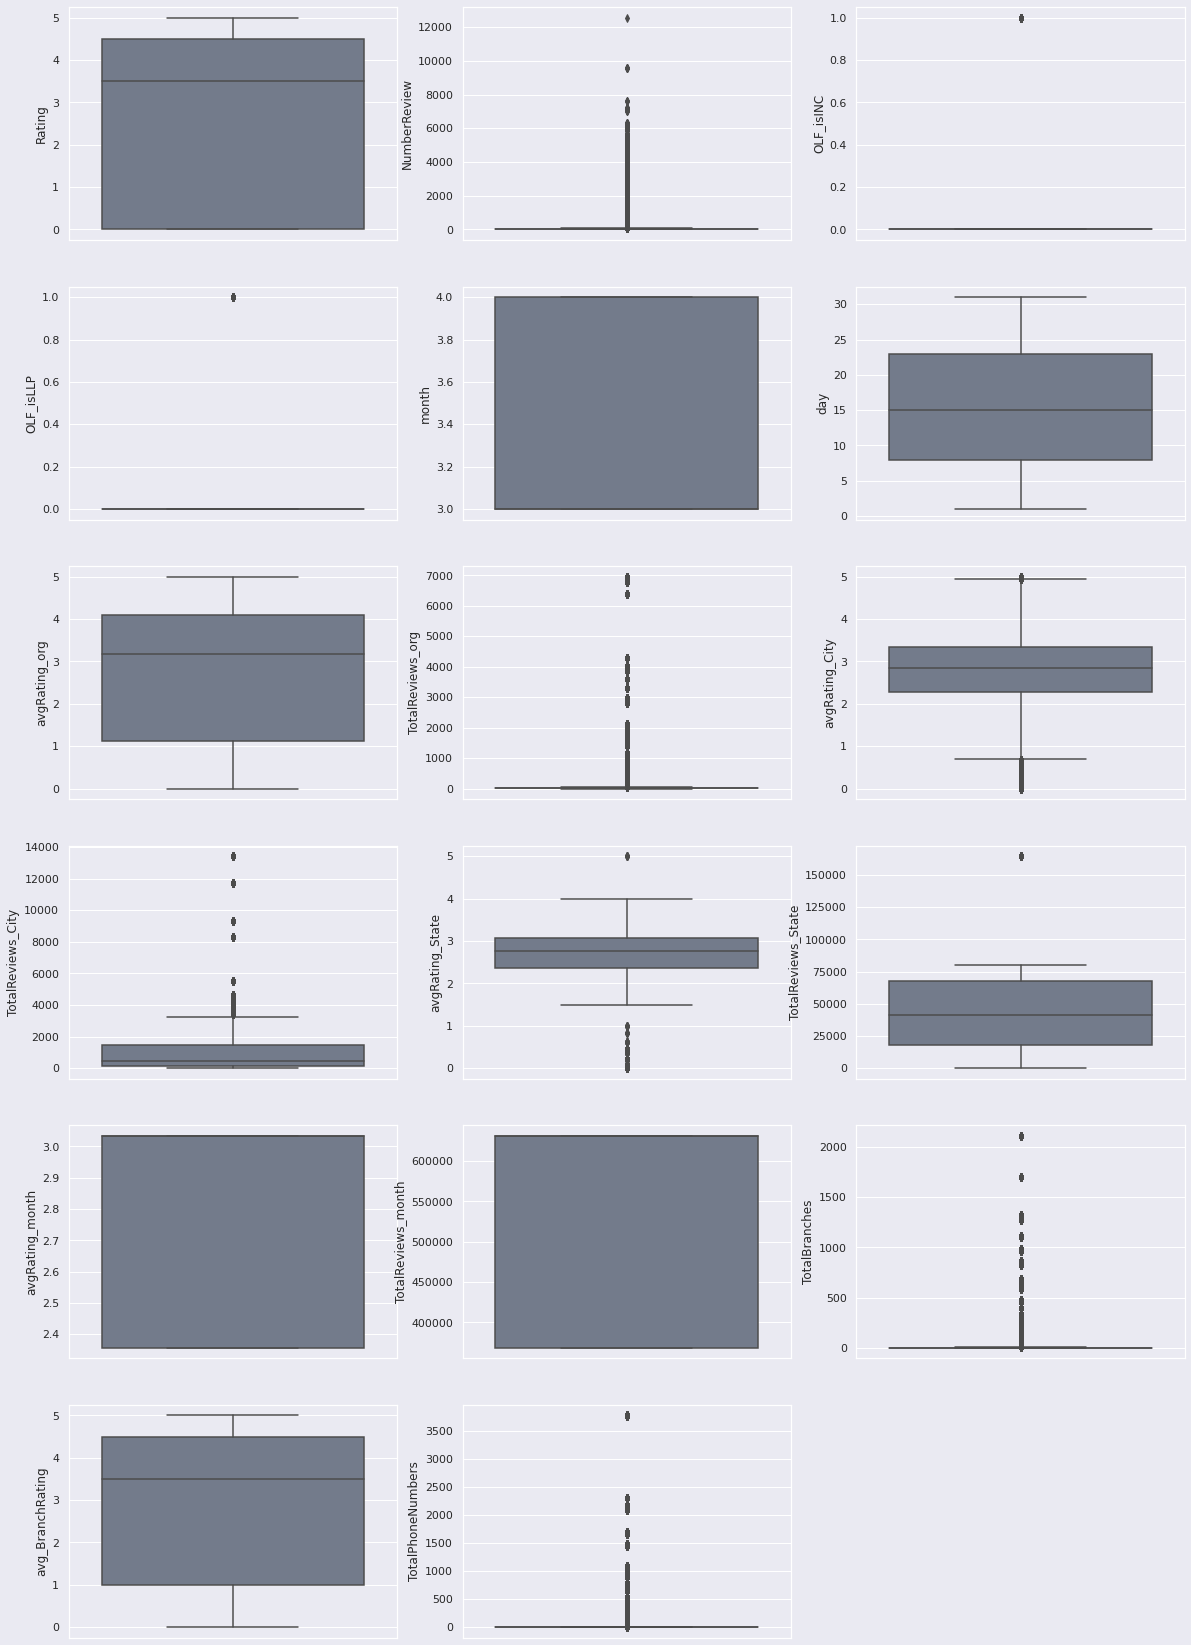

In [ ]:
#Plotting Numerical Distributions
sns.set_style("darkgrid", {"axes.facecolor": "#EAEAF2", "figure.facecolor":"#EAEAF2"})
plt.figure(figsize=(20,30))
for i,col in enumerate(num_data.columns, start=1):
    plt.subplot(6,3,i)
    sns.boxplot(y=col,data=num_data, palette='bone_r')
plt.show;

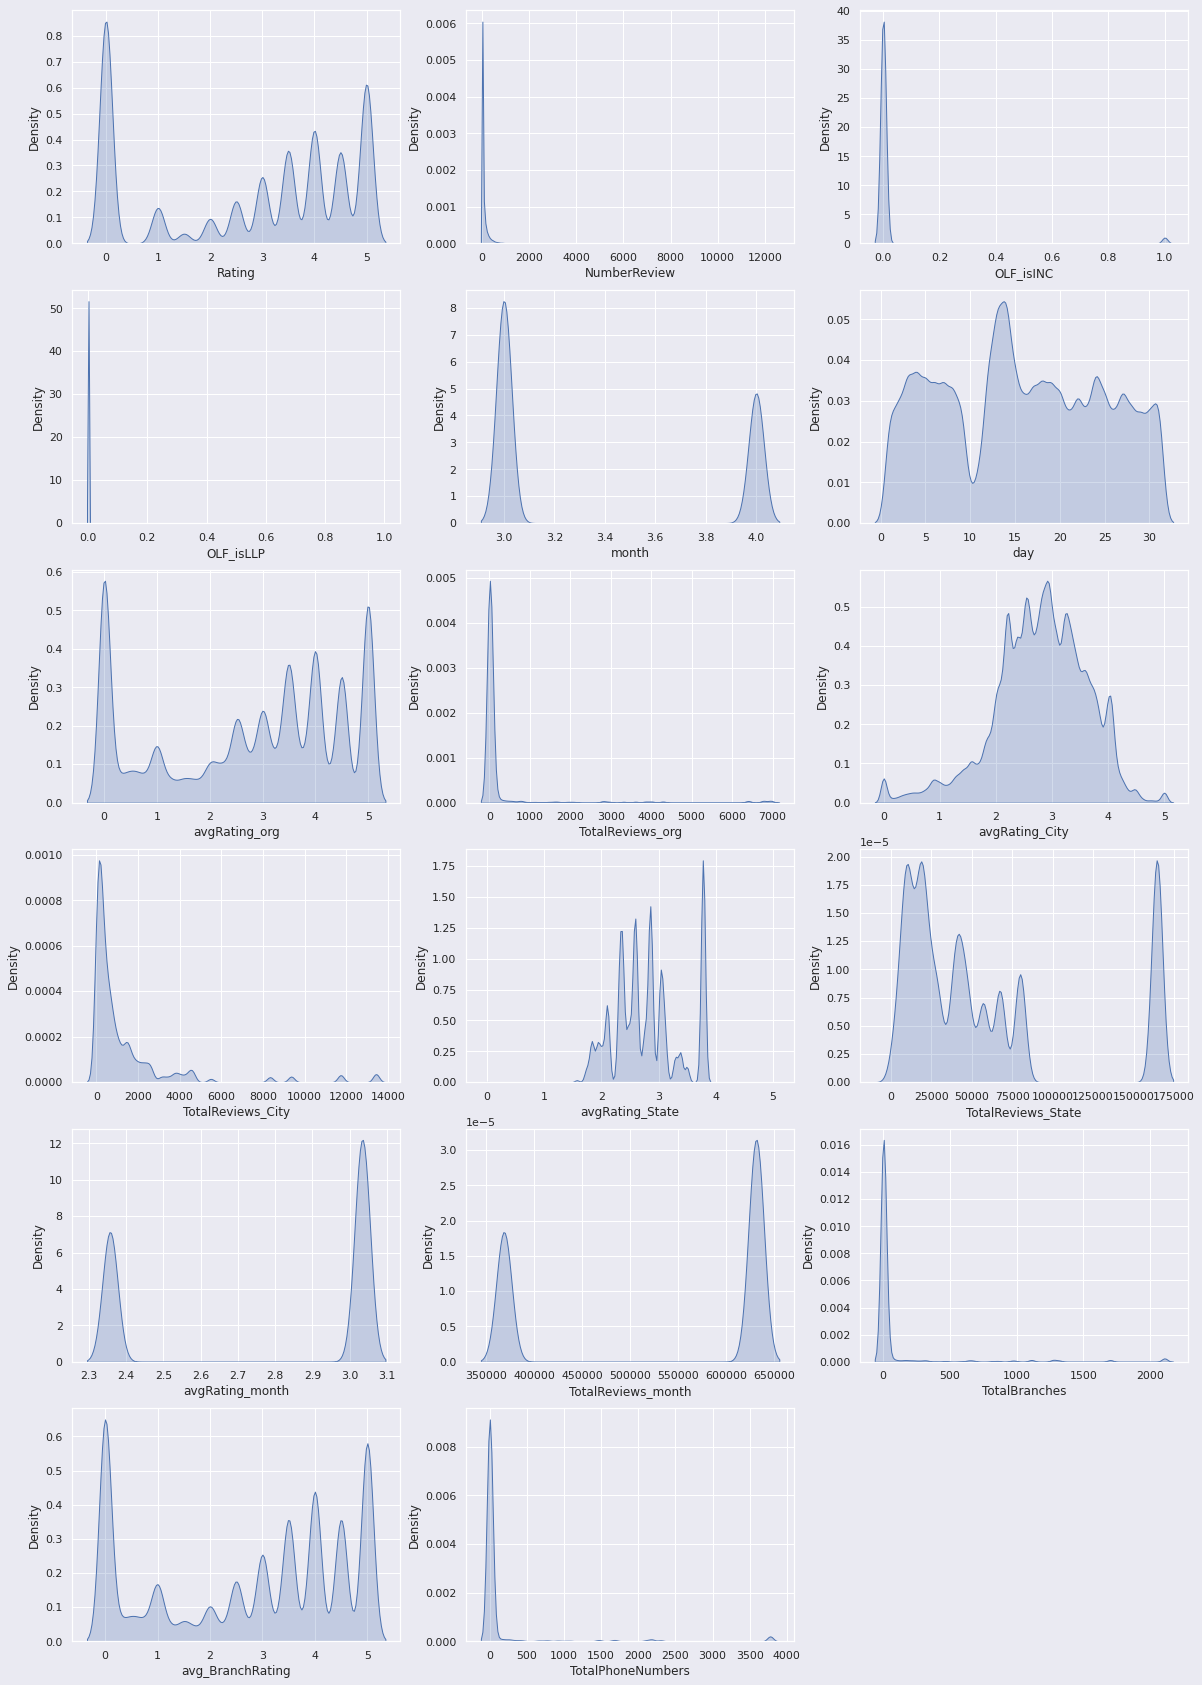

In [ ]:
#Plotting Numerical Distributions
#sns.set_style("darkgrid", {"axes.facecolor": "#FAF0F1", "figure.facecolor":"#FAF0F1"})
plt.figure(figsize=(20,30))
for i,col in enumerate(num_data.columns, start=1):
    plt.subplot(6,3,i)
    sns.kdeplot(x=col, data=num_data, shade=True, palette='bone_r')
plt.show;

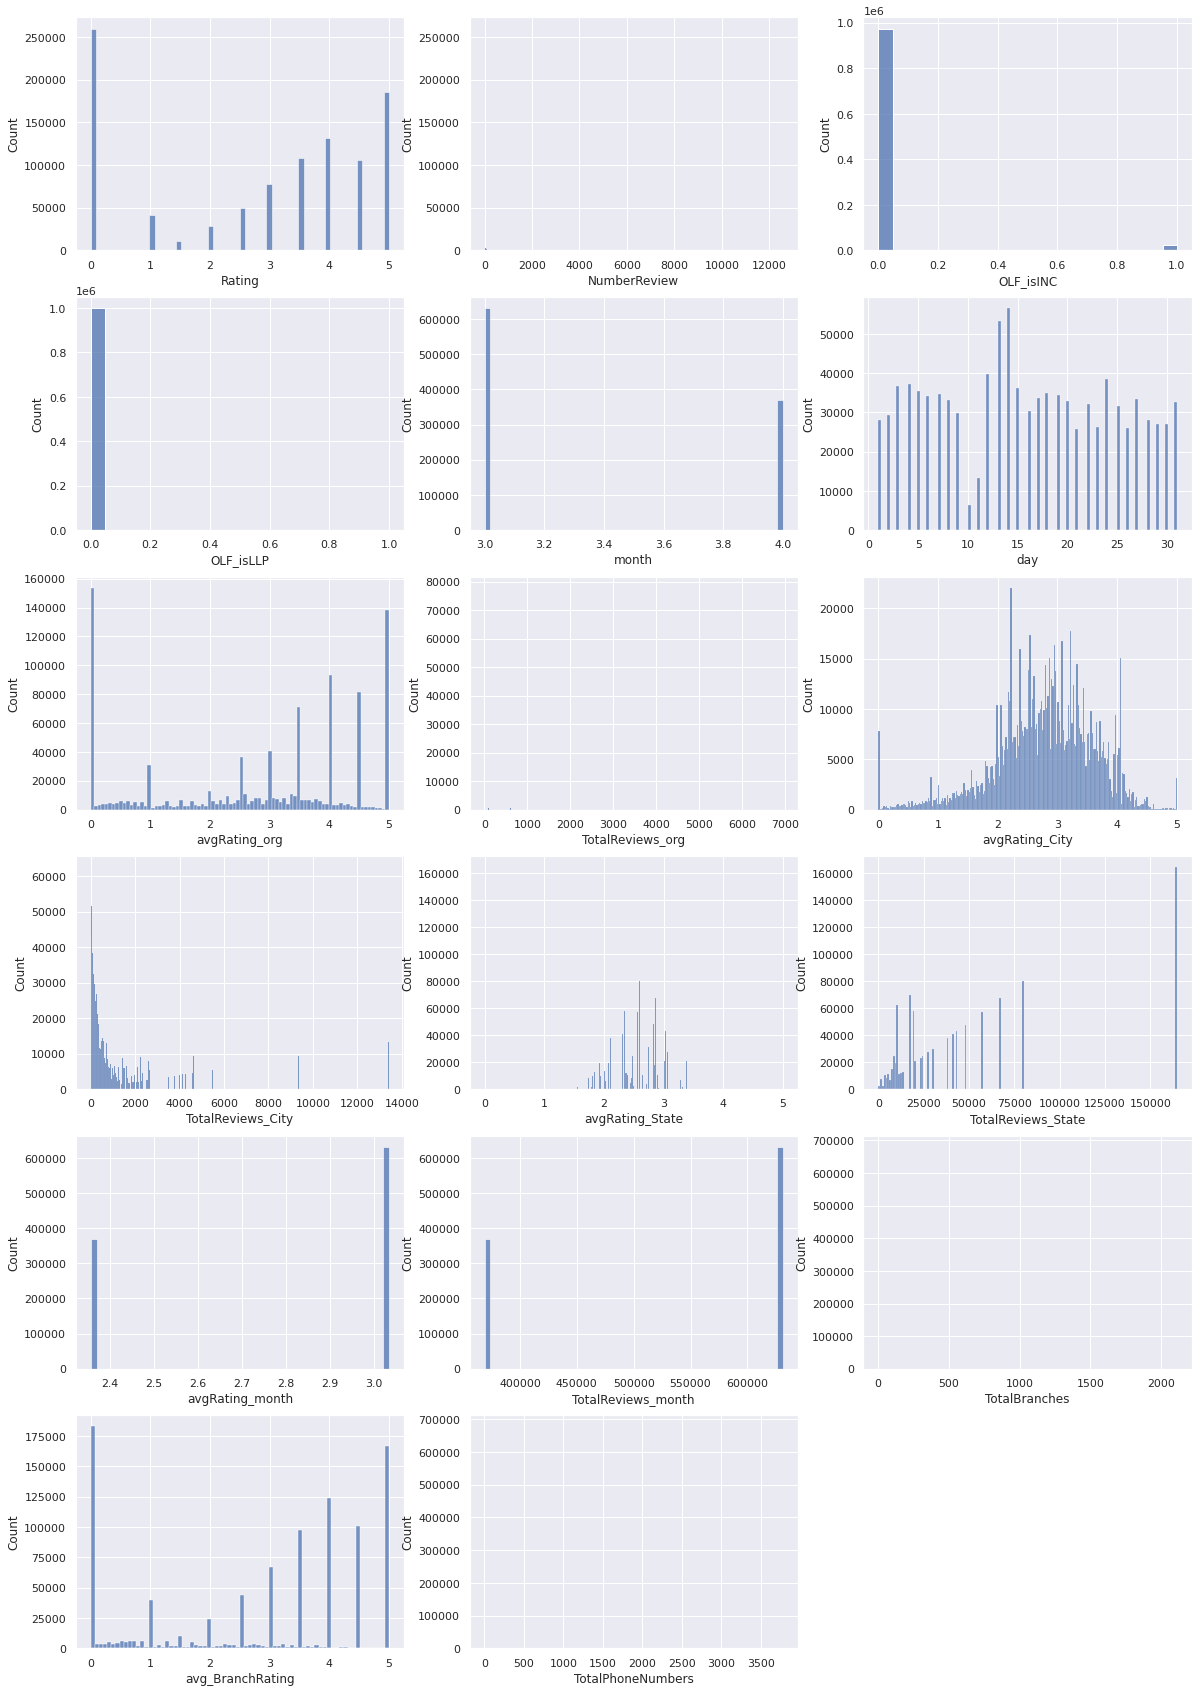

In [ ]:
#Plotting Numerical Distributions
#sns.set_style("darkgrid", {"axes.facecolor": "#FAF0F1", "figure.facecolor":"#FAF0F1"})
plt.figure(figsize=(20,30))
for i,col in enumerate(num_data.columns, start=1):
    plt.subplot(6,3,i)
    sns.histplot(x=col, data=num_data, palette='bone_r')
plt.show;

# EDA (Categorical)

## Sample Statistics

In [ ]:
df.describe(include='object')

,Phone,Organization,Category,State,City,Street,Building
count,1000000,999531,1000000,998942,999531,840385,842059
unique,284109,190703,3,127,12566,190262,26356
top,18772327898,Domino's Pizza,Plumbing,CA,Los Angeles,Main,1
freq,609,6956,510305,164496,13423,10732,2878


## Data Distribution

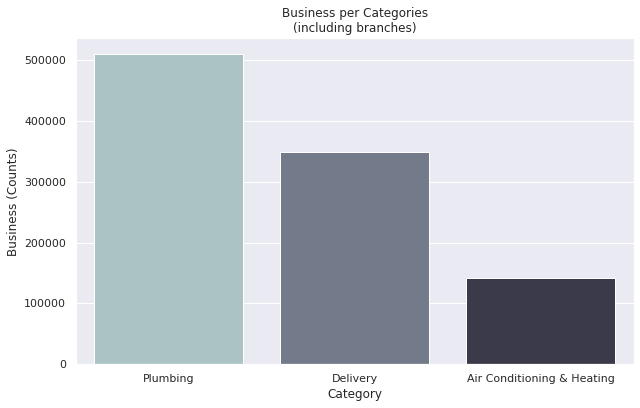

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='Category', data=df, order = df['Category'].value_counts().index, palette='bone_r')
plt.title('Business per Categories\n(including branches)')
plt.ylabel('Business (Counts)')
plt.show()

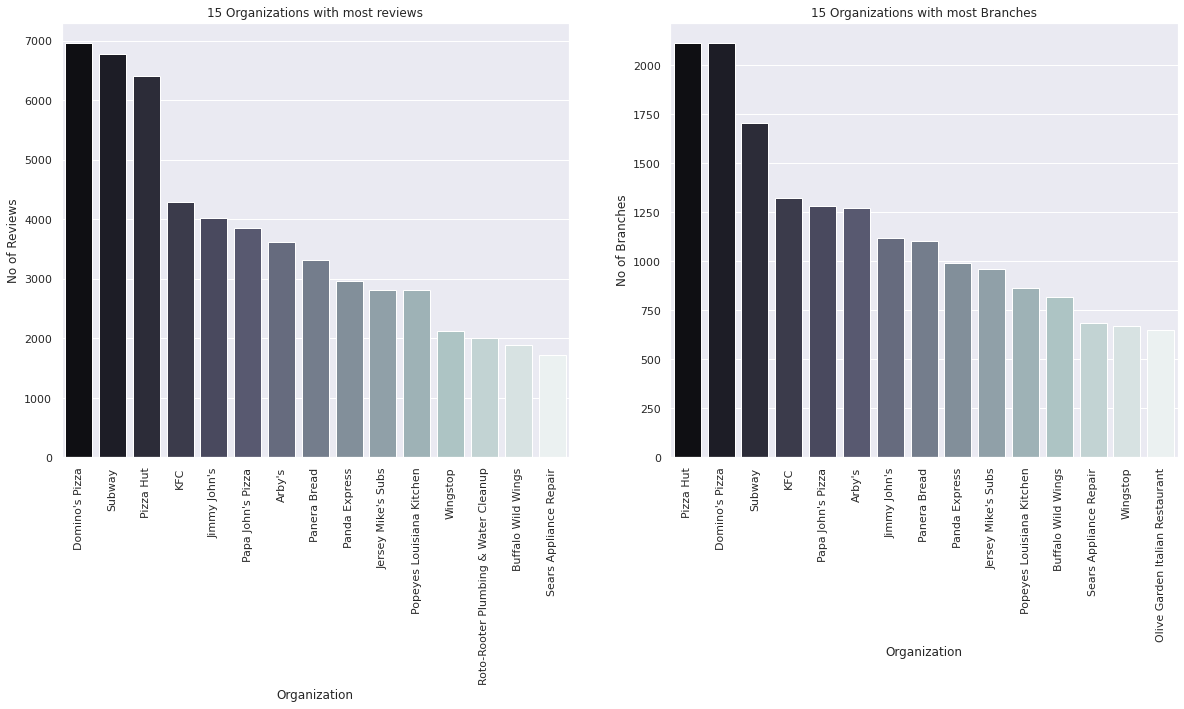

In [ ]:
# Top 15 Org with most reviews and branches

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(y=df['Organization'].value_counts()[:15], x=df['Organization'].value_counts()[:15].index, palette='bone')
plt.ylabel('No of Reviews')
plt.xlabel('Organization')
plt.xticks(rotation=90)
plt.title('15 Organizations with most reviews')

plt.subplot(1,2,2)
sns.barplot(x='Organization',
            y='TotalBranches',
            data = df.drop_duplicates('Organization', keep='first').sort_values(by='TotalBranches', ascending=False)[:15],
            palette='bone')

plt.ylabel('No of Branches')
plt.xlabel('Organization')
plt.xticks(rotation=90)
plt.title('15 Organizations with most Branches')

plt.show()

# Standard Error

In [ ]:
def Bootstrap(data, n_samples):
    bootstrap_metrics = {}
    for col in data.select_dtypes(['int','float']).columns:
        metrics_dict = {}
        col_results=[]
        for n in range(n_samples):
            sample = resample(data[col])
            col_results.append(sample.median())
        col_results = pd.Series(col_results)

        metrics_dict['Original Mean'] = data[col].mean()
        metrics_dict['Original Median'] = data[col].median()
        metrics_dict['Original Std'] = data[col].std()
        metrics_dict['Bootstrap Mean'] = col_results.mean()
        metrics_dict['Bootstrap Median'] = col_results.median()
        metrics_dict['Bootstrap Std'] = col_results.std()
        metrics_dict['Bias Mean'] = col_results.mean() - data[col].mean()
        metrics_dict['Bias Median'] = col_results.median() - data[col].median()
        metrics_dict['Bias Std'] = col_results.std() - data[col].std()
        
        bootstrap_metrics[col] = metrics_dict
    return pd.DataFrame(bootstrap_metrics).T

In [ ]:
Bootstrap(df, 100)

,Original Mean,Original Median,Original Std,Bootstrap Mean,Bootstrap Median,Bootstrap Std,Bias Mean,Bias Median,Bias Std
Rating,2.784374,3.500000,1.914260,3.500000,3.500000,0.000000e+00,0.715626,0.0,-1.914260
NumberReview,56.685617,4.000000,185.571194,4.000000,4.000000,0.000000e+00,-52.685617,0.0,-185.571194
OLF_isINC,0.025657,0.000000,0.158110,0.000000,0.000000,0.000000e+00,-0.025657,0.0,-0.158110
OLF_isLLP,0.000255,0.000000,0.015967,0.000000,0.000000,0.000000e+00,-0.000255,0.0,-0.015967
month,3.368739,3.000000,0.482463,3.000000,3.000000,0.000000e+00,-0.368739,0.0,-0.482463
day,15.775925,15.000000,8.760879,15.000000,15.000000,0.000000e+00,-0.775925,0.0,-8.760879
avgRating_org,2.785680,3.166667,1.723508,3.167608,3.166667,3.941776e-03,0.381928,0.0,-1.719566
TotalReviews_org,292.284234,9.000000,1112.885169,9.000000,9.000000,0.000000e+00,-283.284234,0.0,-1112.885169
avgRating_City,2.785680,2.833333,0.829339,2.833169,2.833333,3.964466e-04,0.047489,0.0,-0.828943
TotalReviews_City,1342.427273,480.000000,2378.639401,480.820000,481.000000,9.783515e-01,-861.607273,1.0,-2377.661049
